In [382]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
import compute_S_rate

In [383]:
def compute_all_walks(c, d, max_tau):
    # Initialize a 2D list with zeros to store walks for each level and time step
    walks = [[0] * (d + 1) for _ in range(max_tau + 1)]
    
    # Initial condition: W(0, 0) = 1
    walks[0][0] = 1
    
    # Fill in the table for each time step tau
    for tau in range(1, max_tau + 1):
        for l in range(d + 1):
            # Apply the recursion relation with boundary conditions
            walks[tau][l] = (walks[tau - 1][l + 1] * c if l + 1 <= d else 0) + \
                            (walks[tau - 1][l - 1] if l - 1 >= 0 else 0)

    return walks


In [384]:
def compute_probabilities(c, d, max_tau):
    # Initialize a 2D array to store probabilities for each level and time step
    probabilities = np.zeros((max_tau + 1, d + 1))
    
    # Set the initial condition: W(0, 0) = 1
    probabilities[0][0] = 1

    # Fill the probabilities table for each time step tau
    for tau in range(1, max_tau + 1):
        for l in range(d + 1):
            # Contribution from level l + 1
            if l + 1 <= d - 1:
                # Apply 1/(c+1) factor for levels other than d-1
                probabilities[tau][l] += probabilities[tau - 1][l + 1] * c / (c + 1)
            elif l + 1 == d:
                # At level d-1, keep the contribution as walks[tau - 1][l + 1] * c
                probabilities[tau][l] += probabilities[tau - 1][l + 1] * c
            
            # Contribution from level l - 1
            if l - 1 > 0:
                # Apply 1/(c+1) factor for levels other than 1
                probabilities[tau][l] += probabilities[tau - 1][l - 1] / (c + 1)
            elif l - 1 == 0:
                # At level 1, use 1/c factor for the root contribution
                probabilities[tau][l] += probabilities[tau - 1][l - 1] / c

    return probabilities


In [385]:
# Parameters
c = 3  # branching factor
d = 5  # maximum depth of the tree
max_tau = 10  # maximum time step to compute

# Calculate probabilities
probabilities = compute_probabilities(c, d, max_tau)

# Print the probabilities for each time step
for tau, probs in enumerate(probabilities):
    print(f"Time step {tau}: {probs}")


Time step 0: [1. 0. 0. 0. 0. 0.]
Time step 1: [0.         0.33333333 0.         0.         0.         0.        ]
Time step 2: [0.25       0.         0.08333333 0.         0.         0.        ]
Time step 3: [0.         0.14583333 0.         0.02083333 0.         0.        ]
Time step 4: [0.109375   0.         0.05208333 0.         0.00520833 0.        ]
Time step 5: [0.         0.07552083 0.         0.01692708 0.         0.00130208]
Time step 6: [0.05664062 0.         0.03157552 0.         0.00813802 0.        ]
Time step 7: [0.         0.04256185 0.         0.0139974  0.         0.00203451]
Time step 8: [0.03192139 0.         0.02113851 0.         0.00960286 0.        ]
Time step 9: [0.         0.02649434 0.         0.01248678 0.         0.00240072]
Time step 10: [0.01987076 0.         0.01598867 0.         0.01032384 0.        ]


In [386]:
node_levels = [pow(c, l) for l in range(d+1)]
print(node_levels)

[1, 3, 9, 27, 81, 243]


In [387]:
# Parameters
c = 3  # branching factor
d = 5  # maximum depth of the tree
max_tau = 4  # maximum time step to compute

# Calculate and print walks for each time step
all_walks = compute_all_walks(c, d, max_tau)
for tau, walks in enumerate(all_walks):
    print(f"Time step {tau}: {walks}")


Time step 0: [1, 0, 0, 0, 0, 0]
Time step 1: [0, 1, 0, 0, 0, 0]
Time step 2: [3, 0, 1, 0, 0, 0]
Time step 3: [0, 6, 0, 1, 0, 0]
Time step 4: [18, 0, 9, 0, 1, 0]


In [388]:
all_walks

[[1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0],
 [3, 0, 1, 0, 0, 0],
 [0, 6, 0, 1, 0, 0],
 [18, 0, 9, 0, 1, 0]]

In [389]:
levels_walks =[np.array(all_walks[l]) * node_levels for l in range(max_tau+1)]
levels_prob = [walks / np.sum(walks) for walks in levels_walks]
entries_prob = [probs / node_levels for probs in levels_prob]

In [390]:
print(levels_walks)
print(levels_prob)
print(entries_prob)


[array([1, 0, 0, 0, 0, 0]), array([0, 3, 0, 0, 0, 0]), array([3, 0, 9, 0, 0, 0]), array([ 0, 18,  0, 27,  0,  0]), array([18,  0, 81,  0, 81,  0])]
[array([1., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0.]), array([0.25, 0.  , 0.75, 0.  , 0.  , 0.  ]), array([0. , 0.4, 0. , 0.6, 0. , 0. ]), array([0.1 , 0.  , 0.45, 0.  , 0.45, 0.  ])]
[array([1., 0., 0., 0., 0., 0.]), array([0.        , 0.33333333, 0.        , 0.        , 0.        ,
       0.        ]), array([0.25      , 0.        , 0.08333333, 0.        , 0.        ,
       0.        ]), array([0.        , 0.13333333, 0.        , 0.02222222, 0.        ,
       0.        ]), array([0.1       , 0.        , 0.05      , 0.        , 0.00555556,
       0.        ])]


In [391]:
print(entries_prob[-1])

[0.1        0.         0.05       0.         0.00555556 0.        ]


# Regular Branching Tree

In [392]:
def branching_tree_adjacency_matrix(c, d):
    # Total number of nodes in the tree
    total_nodes = sum(c ** i for i in range(d + 1))
    
    # Initialize an empty adjacency matrix
    adjacency_matrix = np.zeros((total_nodes, total_nodes), dtype=int)
    
    # Keep track of the current node index at each level
    current_index = 0
    
    # Loop through each level in the tree
    for level in range(d):
        # Number of nodes at the current level
        nodes_at_level = c ** level
        # Number of nodes at the next level
        nodes_at_next_level = c ** (level + 1)
        
        # For each node at the current level, connect it to `c` children at the next level
        for node in range(nodes_at_level):
            # Calculate the index of the first child at the next level
            parent_index = current_index + node
            first_child_index = current_index + nodes_at_level + node * c
            # Connect to each child (if within bounds)
            for child_offset in range(c):
                child_index = first_child_index + child_offset
                if child_index < current_index + nodes_at_level + nodes_at_next_level:
                    adjacency_matrix[parent_index, child_index] = 1
                    adjacency_matrix[child_index, parent_index] = 1

        # Move the current index to the start of the next level
        current_index += nodes_at_level
    
    return adjacency_matrix


In [393]:
# Parameters
c = 3  # number of children per node
d = 5  # depth of the tree

# Generate the adjacency matrix
adj_matrix = branching_tree_adjacency_matrix(c, d)


In [394]:
def Discrete_RW_T(A):    # Calculate the degree vector (sum of non-zero elements in each row)
    degree_vector = np.array(A.sum(axis=1)).ravel()

    # Avoid division by zero by setting degree to 1 for nodes with no edges
    no_out_edges = degree_vector == 0
    degree_vector[no_out_edges] = 1.0

    # Create a diagonal matrix from the inverted degree vector
    degree_matrix = np.diag(1.0 / degree_vector)

    # Calculate the random walk Transition matrix: T = D^(-1) * A
    T = degree_matrix @ A
    np.fill_diagonal(T, no_out_edges, wrap=False)
    return T

### Check if regular branching tree probs are the same as the ones obtained with our algorithm

In [395]:
def representative_indices(c, d):
    indices = []
    current_index = 0  # Start at the root node (index 0)
    
    for level in range(d + 1):
        indices.append(current_index)  # Add the first node of this level
        current_index += c ** level  # Move to the start of the next level
        
    return indices

level_indeces = representative_indices(c,d)
print(level_indeces)

[0, 1, 4, 13, 40, 121]


In [396]:
T = Discrete_RW_T(adj_matrix)
times = range(11)

list_power_T = []
for t in times:
    power_T = np.linalg.matrix_power(T, t)
    list_power_T.append(power_T[0,level_indeces])

# Print the probabilities for each time step
for tau, probs in enumerate(list_power_T):
    print(f"Time step {tau}: {probs}")

# Print the probabilities for each time step
for tau, probs in enumerate(probabilities):
    print(f"Time step {tau}: {probs}")

Time step 0: [1. 0. 0. 0. 0. 0.]
Time step 1: [0.         0.33333333 0.         0.         0.         0.        ]
Time step 2: [0.25       0.         0.08333333 0.         0.         0.        ]
Time step 3: [0.         0.14583333 0.         0.02083333 0.         0.        ]
Time step 4: [0.109375   0.         0.05208333 0.         0.00520833 0.        ]
Time step 5: [0.         0.07552083 0.         0.01692708 0.         0.00130208]
Time step 6: [0.05664063 0.         0.03157552 0.         0.00813802 0.        ]
Time step 7: [0.         0.04256185 0.         0.0139974  0.         0.00203451]
Time step 8: [0.03192139 0.         0.02113851 0.         0.00960286 0.        ]
Time step 9: [0.         0.02649434 0.         0.01248678 0.         0.00240072]
Time step 10: [0.01987076 0.         0.01598867 0.         0.01032384 0.        ]
Time step 0: [1. 0. 0. 0. 0. 0.]
Time step 1: [0.         0.33333333 0.         0.         0.         0.        ]
Time step 2: [0.25       0.         0.0833

# Stochastic Branching Process

In [397]:
def stochastic_branching_tree_adjacency_matrix(distr, d):
    # Start with a list to track nodes at each level
    levels = [[0]]  # Root node is at level 0
    
    # Adjacency list to build the tree dynamically
    adjacency_list = []
    node_index = 1  # Index of the next node to be added

    # Generate the tree level by level up to depth d
    for level in range(d):
        current_level = levels[level]
        next_level = []
        
        # For each node in the current level, sample the number of children
        for parent in current_level:
            num_children = distr()
            children = []

            for _ in range(num_children):
                children.append(node_index)
                adjacency_list.append((parent, node_index))  # Add edge to adjacency list
                node_index += 1

            next_level.extend(children)  # Add children to the next level

        if next_level:
            levels.append(next_level)
        else:
            break  # Stop if no new children were added

    # Convert adjacency list to adjacency matrix
    total_nodes = node_index
    adjacency_matrix = np.zeros((total_nodes, total_nodes), dtype=int)
    
    for parent, child in adjacency_list:
        adjacency_matrix[parent, child] = 1
        adjacency_matrix[child, parent] = 1  # Symmetric for undirected tree

    return adjacency_matrix


In [398]:
# Define a distribution function, e.g., a Poisson distribution with mean 3
distr = lambda: np.random.poisson(3)

# Parameters
d = 5  # maximum depth of the tree

# Generate the stochastic adjacency matrix
stoch_adj_matrix = stochastic_branching_tree_adjacency_matrix(distr, d)
print(stoch_adj_matrix)


[[0 1 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [399]:
T = Discrete_RW_T(stoch_adj_matrix)
times = range(100)

list_power_T = []
for t in times:
    power_T = np.linalg.matrix_power(T, t)
    list_power_T.append(power_T[0,:])

In [400]:
list_H_stochtree = []
for power_T in list_power_T:
    logpowTdata = np.log(np.where(power_T > 0, power_T, 1))
    powTlogpowTdata = power_T * logpowTdata
    row_entropy = -np.sum(powTlogpowTdata)
    list_H_stochtree.append(row_entropy)

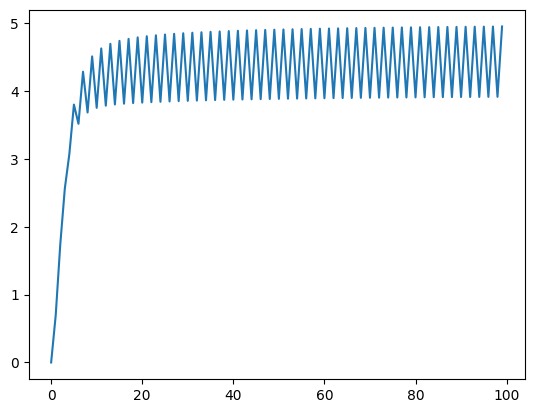

In [401]:
plt.plot(list_H_stochtree)

## Approximation with regular tree

In [402]:
# Parameters
c = 3  # branching factor
d = 7  # maximum depth of the tree
max_tau = 25  # maximum time step to compute

# Calculate probabilities
probabilities = compute_probabilities(c, d, max_tau)

In [403]:
node_levels = [pow(c, l) for l in range(d+1)]
print(node_levels)

[1, 3, 9, 27, 81, 243, 729, 2187]


In [404]:
list_H_regtree = []
for prob in probabilities:
    logprob = np.log(np.where(prob > 0, prob, 1))
    problogprob = prob * logprob
    row_entropy = -np.sum(node_levels * problogprob)
    list_H_regtree.append(row_entropy)

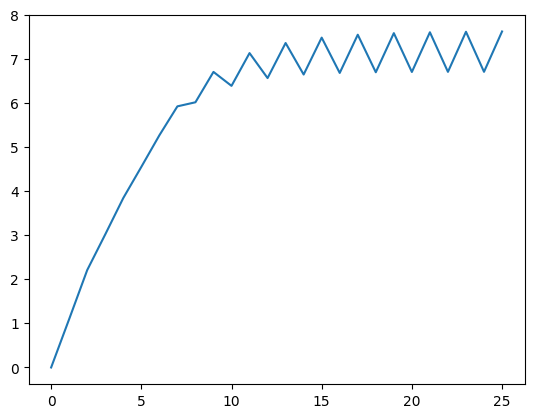

In [405]:
plt.plot(list_H_regtree)

In [406]:
# # Parameters
# c = 3  # branching factor (example)
# d = 7  # depth of the tree
# sample_size = 50  # number of graphs in the sample

# # Distribution function for number of children (example with Poisson)
# distr = lambda: np.random.poisson(3)

# # Generate sample of graphs and compute list_H_stochtree for each
# lists_H_stochtree = []

# for _ in range(sample_size):
#     adj_matrix = stochastic_branching_tree_adjacency_matrix(distr, d)
    
#     T = Discrete_RW_T(adj_matrix)
#     times = range(max_tau + 1)
#     list_power_T = []
#     for t in times:
#         power_T = np.linalg.matrix_power(T, t)
#         list_power_T.append(power_T[0,:])

#     H_stochtree = []
#     for power_T in list_power_T:
#         logpowTdata = np.log(np.where(power_T > 0, power_T, 1))
#         powTlogpowTdata = power_T * logpowTdata
#         row_entropy = -np.sum(powTlogpowTdata)
#         H_stochtree.append(row_entropy)
#     lists_H_stochtree.append(H_stochtree)

# # Convert list of lists to a 2D numpy array for easier computation of the average
# lists_H_stochtree = np.array(lists_H_stochtree)

# # Compute the average across all trees (average of each position)
# average_H_stochtree = np.mean(lists_H_stochtree, axis=0)
# # Compute the median across all trees (average of each position)
# median_H_stochtree = np.median(lists_H_stochtree, axis=0)

# # Create a plot
# plt.figure(figsize=(10, 6))

# # Plot each list in gray with transparency
# for list_H in lists_H_stochtree:
#     plt.plot(list_H, color='gray', alpha=0.3)

# # Plot the average of all lists in a distinct color (e.g., blue)
# plt.plot(average_H_stochtree, color='blue', linewidth=2, label="Average")
# # Plot the median of all lists in a distinct color (e.g., blue)
# plt.plot(median_H_stochtree, color='cyan', linewidth=2, label="Median")


# # Plot list_H_regtree in red on top (assuming this is provided)
# plt.plot(list_H_regtree, color='red', linewidth=2, label="Additional list_H_stochtree")

# # Add labels and legend
# plt.xlabel("Index")
# plt.ylabel("Value")
# plt.legend()
# plt.title("Sample of Stochastic Branching Tree Values")

# # Show the plot
# plt.show()


In [407]:
# Parameters
c = 5  # branching factor
d = 6  # maximum depth of the tree
max_tau = 25  # maximum time step to compute

# Calculate probabilities
probabilities = compute_probabilities(c, d, max_tau)

In [408]:
node_levels = [pow(c, l) for l in range(d+1)]
print(node_levels)

[1, 5, 25, 125, 625, 3125, 15625]


In [409]:
list_H_regtree = []
for prob in probabilities:
    logprob = np.log(np.where(prob > 0, prob, 1))
    problogprob = prob * logprob
    row_entropy = -np.sum(node_levels * problogprob)
    list_H_regtree.append(row_entropy)

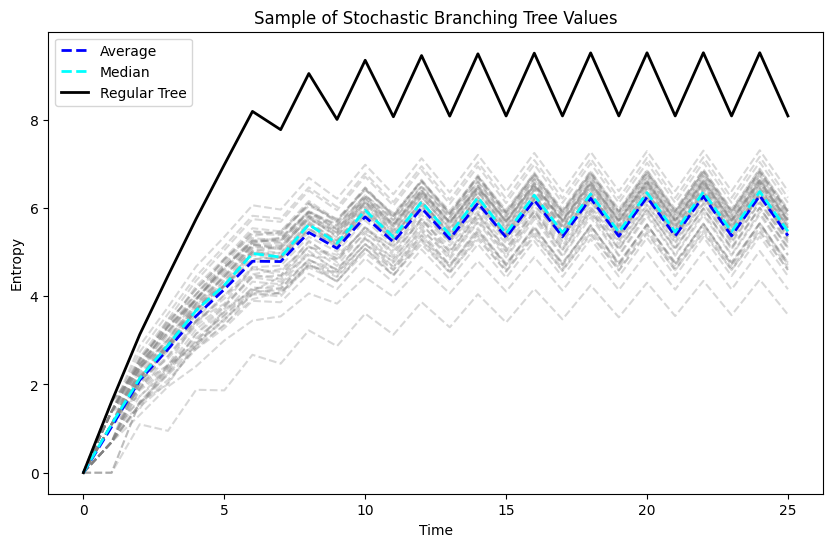

In [410]:
# Parameters
c = 5  # branching factor (example)
d = 6  # depth of the tree
sample_size = 50  # number of graphs in the sample

# Distribution function for number of children (example with Poisson)
distr = lambda: np.random.binomial(6, 0.5)

# Generate sample of graphs and compute list_H_stochtree for each
lists_H_stochtree = []

for _ in range(sample_size):
    adj_matrix = stochastic_branching_tree_adjacency_matrix(distr, d)
    
    T = Discrete_RW_T(adj_matrix)
    times = range(max_tau + 1)
    list_power_T = []
    for t in times:
        power_T = np.linalg.matrix_power(T, t)
        list_power_T.append(power_T[0,:])

    H_stochtree = []
    for power_T in list_power_T:
        logpowTdata = np.log(np.where(power_T > 0, power_T, 1))
        powTlogpowTdata = power_T * logpowTdata
        row_entropy = -np.sum(powTlogpowTdata)
        H_stochtree.append(row_entropy)
    lists_H_stochtree.append(H_stochtree)

# Convert list of lists to a 2D numpy array for easier computation of the average
lists_H_stochtree = np.array(lists_H_stochtree)

# Compute the average across all trees (average of each position)
average_H_stochtree = np.mean(lists_H_stochtree, axis=0)
# Compute the median across all trees (average of each position)
median_H_stochtree = np.median(lists_H_stochtree, axis=0)

# Create a plot
plt.figure(figsize=(10, 6))

# Plot each list in gray with transparency
for list_H in lists_H_stochtree:
    plt.plot(list_H, '--', color='gray', alpha=0.3)

# Plot the average of all lists in a distinct color (e.g., blue)
plt.plot(average_H_stochtree, '--', color='blue', linewidth=2, label="Average")
# Plot the median of all lists in a distinct color (e.g., blue)
plt.plot(median_H_stochtree, '--', color='cyan', linewidth=2, label="Median")


# Plot list_H_regtree in red on top 
plt.plot(list_H_regtree, color='black', linewidth=2, label="Regular Tree")

# Add labels and legend
plt.xlabel("Time")
plt.ylabel("Entropy")
plt.legend()
plt.title("Sample of Stochastic Branching Tree Values")

#plt.savefig('/home/b/skoove/Desktop/plots_entropy/GW_vs_RegularTree.png', format='png', dpi=300)
# Show the plot
plt.show()

## With non integer value of c

In [411]:
# Parameters
c = 5.5  # branching factor
d = 6  # maximum depth of the tree
max_tau = 25  # maximum time step to compute

# Calculate probabilities
probabilities = compute_probabilities(c, d, max_tau)

In [412]:
node_levels = [pow(c, l) for l in range(d+1)]
print(node_levels)

[1.0, 5.5, 30.25, 166.375, 915.0625, 5032.84375, 27680.640625]


In [413]:
list_H_regtree = []
for prob in probabilities:
    logprob = np.log(np.where(prob > 0, prob, 1))
    problogprob = prob * logprob
    row_entropy = -np.sum(node_levels * problogprob)
    list_H_regtree.append(row_entropy)

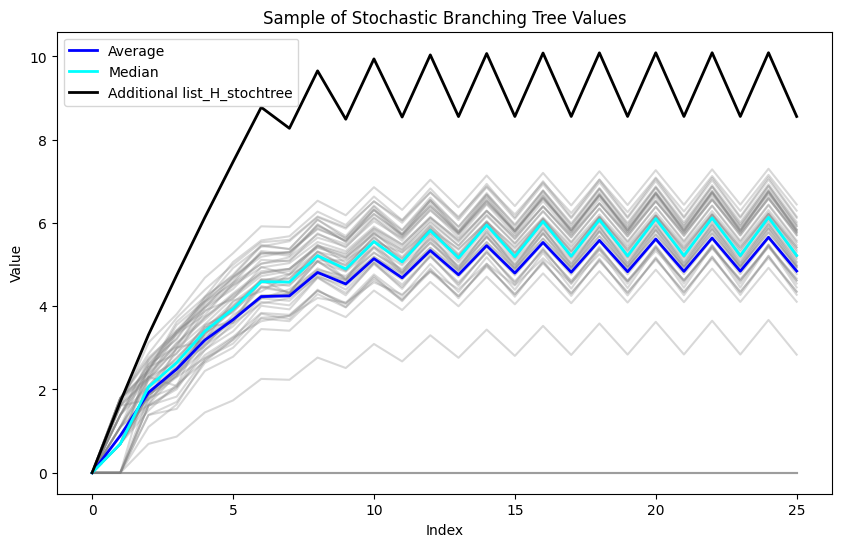

In [414]:
# Parameters
c = 5.5  # branching factor (example)
d = 6  # depth of the tree
sample_size = 50  # number of graphs in the sample

# Distribution function for number of children (example with Poisson)
distr = lambda: np.random.poisson(3)

# Generate sample of graphs and compute list_H_stochtree for each
lists_H_stochtree = []

for _ in range(sample_size):
    adj_matrix = stochastic_branching_tree_adjacency_matrix(distr, d)
    
    T = Discrete_RW_T(adj_matrix)
    times = range(max_tau + 1)
    list_power_T = []
    for t in times:
        power_T = np.linalg.matrix_power(T, t)
        list_power_T.append(power_T[0,:])

    H_stochtree = []
    for power_T in list_power_T:
        logpowTdata = np.log(np.where(power_T > 0, power_T, 1))
        powTlogpowTdata = power_T * logpowTdata
        row_entropy = -np.sum(powTlogpowTdata)
        H_stochtree.append(row_entropy)
    lists_H_stochtree.append(H_stochtree)

# Convert list of lists to a 2D numpy array for easier computation of the average
lists_H_stochtree = np.array(lists_H_stochtree)

# Compute the average across all trees (average of each position)
average_H_stochtree = np.mean(lists_H_stochtree, axis=0)
# Compute the median across all trees (average of each position)
median_H_stochtree = np.median(lists_H_stochtree, axis=0)

# Create a plot
plt.figure(figsize=(10, 6))

# Plot each list in gray with transparency
for list_H in lists_H_stochtree:
    plt.plot(list_H, color='gray', alpha=0.3)

# Plot the average of all lists in a distinct color (e.g., blue)
plt.plot(average_H_stochtree, color='blue', linewidth=2, label="Average")
# Plot the median of all lists in a distinct color (e.g., blue)
plt.plot(median_H_stochtree, color='cyan', linewidth=2, label="Median")


# Plot list_H_regtree in red on top (assuming this is provided)
plt.plot(list_H_regtree, color='black', linewidth=2, label="Additional list_H_stochtree")

# Add labels and legend
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.title("Sample of Stochastic Branching Tree Values")

# Show the plot
plt.show()

## Continuous-Time Comparison

In [421]:
adj_matrix.shape

(516, 516)

In [450]:
a = branching_tree_adjacency_matrix(4, 4)
print(a.shape)

# Distribution function for number of children (example with Poisson)
distr = lambda: np.random.poisson(4)
b = stochastic_branching_tree_adjacency_matrix(distr = distr, d=4)
print(b.shape)

(341, 341)
(141, 141)


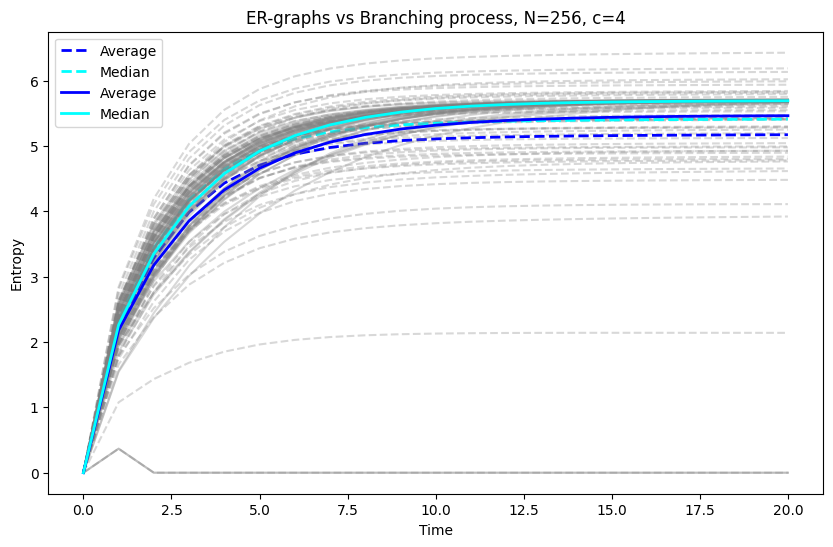

In [451]:
# Parameters ER graphs
N = 341
c = 4
p = c / N


# Parameters Branching process
c = 4  # branching factor (example)
d = 4  # depth of the tree

max_tau = 20
sample_size = 50 # number of graphs in the sample


# Distribution function for number of children (example with Poisson)
distr = lambda: np.random.poisson(4)

# Generate sample of graphs and compute list_H_stochtree for each
lists_H_stochtree = []



for _ in range(sample_size):
    adj_matrix = stochastic_branching_tree_adjacency_matrix(distr, d)
    
    stochtree_rw = StaticTempNetwork(times = times, adjacency = csr_matrix(adj_matrix))
    stochtree_rw.compute_laplacian_matrices(random_walk = True)

    stochtree_rw.compute_inter_transition_matrices(lamda=1, dense_expm=False, use_sparse_stoch=False)
    stochtree_rw.compute_transition_matrices(lamda=1)

    p_source = np.zeros(adj_matrix.shape[0])
    p_source[0] = 1
    H_stochtree_rw = compute_S_rate.compute_conditional_entropy(net=stochtree_rw, list_T=stochtree_rw.T[1], lamda=1, force_csr=True, time_domain= list(range(len(times)-1)), p0 = p_source)
    
    # T = Discrete_RW_T(adj_matrix)
    # times = range(max_tau + 1)
    # list_power_T = []
    # for t in times:
    #     power_T = np.linalg.matrix_power(T, t)
    #     list_power_T.append(power_T[0,:])

    # H_stochtree = []
    # for power_T in list_power_T:
    #     logpowTdata = np.log(np.where(power_T > 0, power_T, 1))
    #     powTlogpowTdata = power_T * logpowTdata
    #     row_entropy = -np.sum(powTlogpowTdata)
    #     H_stochtree.append(row_entropy)
    # lists_H_stochtree.append(H_stochtree)
    
    lists_H_stochtree.append(H_stochtree_rw[list(H_stochtree_rw.keys())[0]])

# Convert list of lists to a 2D numpy array for easier computation of the average
lists_H_stochtree = np.array(lists_H_stochtree)

# Compute the average across all trees (average of each position)
average_H_stochtree = np.mean(lists_H_stochtree, axis=0)
# Compute the median across all trees (average of each position)
median_H_stochtree = np.median(lists_H_stochtree, axis=0)

# Create a plot
plt.figure(figsize=(10, 6))

# Plot each list in gray with transparency
for list_H in lists_H_stochtree:
    plt.plot(list_H, '--', color='gray', alpha=0.3)

# Plot the average of all lists in a distinct color (e.g., blue)
plt.plot(average_H_stochtree, '--', color='blue', linewidth=2, label="Average")
# Plot the median of all lists in a distinct color (e.g., blue)
plt.plot(median_H_stochtree, '--', color='cyan', linewidth=2, label="Median")



p_source = np.zeros(N)
p_source[0] = 1

lists_H_er = []
for _ in range(sample_size):
    adj_matrix = nx.adjacency_matrix(nx.erdos_renyi_graph(N, p))
    er_rw = StaticTempNetwork(times = times, adjacency = csr_matrix(adj_matrix))
    er_rw.compute_laplacian_matrices(random_walk = True)

    er_rw.compute_inter_transition_matrices(lamda=1, dense_expm=False, use_sparse_stoch=False)
    er_rw.compute_transition_matrices(lamda=1)

    H_er_rw = compute_S_rate.compute_conditional_entropy(net=er_rw, list_T=er_rw.T[1], lamda=1, force_csr=True, time_domain= list(range(len(times)-1)), p0 = p_source)
    # T = Discrete_RW_T(adj_matrix)
    # times = range(max_tau + 1)
    # list_power_T = []
    # for t in times:
    #     power_T = np.linalg.matrix_power(T, t)
    #     list_power_T.append(power_T[0,:])

    # H_er = []
    # for power_T in list_power_T:
    #     logpowTdata = np.log(np.where(power_T > 0, power_T, 1))
    #     powTlogpowTdata = power_T * logpowTdata
    #     row_entropy = -np.sum(powTlogpowTdata)
    #     H_er.append(row_entropy)
    # lists_H_er.append(H_er)

    lists_H_er.append(H_er_rw[list(H_er_rw.keys())[0]])
# Convert list of lists to a 2D numpy array for easier computation of the average
lists_H_er = np.array(lists_H_er)

# Compute the average across all trees (average of each position)
average_H_er = np.mean(lists_H_er, axis=0)
# Compute the median across all trees (average of each position)
median_H_er = np.median(lists_H_er, axis=0)


# Plot each list in gray with transparency
for list_H in lists_H_er:
    plt.plot(list_H, color='gray', alpha=0.3)

# Plot the average of all lists in a distinct color (e.g., blue)
plt.plot(average_H_er, color='blue', linewidth=2, label="Average")
# Plot the median of all lists in a distinct color (e.g., blue)
plt.plot(median_H_er, color='cyan', linewidth=2, label="Median")



# Add labels and legend
plt.xlabel("Time")
plt.ylabel("Entropy")
plt.legend()
plt.title("ER-graphs vs Branching process, N=341, c=4")
#plt.savefig('/home/b/skoove/Desktop/plots_entropy/DTRW_ER_vs_GW.png', format='png', dpi=300)
# Show the plot
plt.show()

### Second Experiment

In [462]:
a = branching_tree_adjacency_matrix(3, 6)
print(a.shape)

# Distribution function for number of children (example with Poisson)
distr = lambda: np.random.poisson(3)
b = stochastic_branching_tree_adjacency_matrix(distr = distr, d=6)
print(b.shape)

(1093, 1093)
(2872, 2872)


In [463]:
# Parameters ER graphs
N = 1093
c = 3
p = c / N


# Parameters Branching process
c = 3  # branching factor (example)
d = 6  # depth of the tree

max_tau = 20
sample_size = 50 # number of graphs in the sample


# Distribution function for number of children (example with Poisson)
distr = lambda: np.random.poisson(4)

# Generate sample of graphs and compute list_H_stochtree for each
lists_H_stochtree = []



for _ in range(sample_size):
    adj_matrix = stochastic_branching_tree_adjacency_matrix(distr, d)
    
    stochtree_rw = StaticTempNetwork(times = times, adjacency = csr_matrix(adj_matrix))
    stochtree_rw.compute_laplacian_matrices(random_walk = True)

    stochtree_rw.compute_inter_transition_matrices(lamda=1, dense_expm=False, use_sparse_stoch=False)
    stochtree_rw.compute_transition_matrices(lamda=1)

    p_source = np.zeros(adj_matrix.shape[0])
    p_source[0] = 1
    H_stochtree_rw = compute_S_rate.compute_conditional_entropy(net=stochtree_rw, list_T=stochtree_rw.T[1], lamda=1, force_csr=True, time_domain= list(range(len(times)-1)), p0 = p_source)
    
    # T = Discrete_RW_T(adj_matrix)
    # times = range(max_tau + 1)
    # list_power_T = []
    # for t in times:
    #     power_T = np.linalg.matrix_power(T, t)
    #     list_power_T.append(power_T[0,:])

    # H_stochtree = []
    # for power_T in list_power_T:
    #     logpowTdata = np.log(np.where(power_T > 0, power_T, 1))
    #     powTlogpowTdata = power_T * logpowTdata
    #     row_entropy = -np.sum(powTlogpowTdata)
    #     H_stochtree.append(row_entropy)
    # lists_H_stochtree.append(H_stochtree)
    
    lists_H_stochtree.append(H_stochtree_rw[list(H_stochtree_rw.keys())[0]])

# Convert list of lists to a 2D numpy array for easier computation of the average
lists_H_stochtree = np.array(lists_H_stochtree)

# Compute the average across all trees (average of each position)
average_H_stochtree = np.mean(lists_H_stochtree, axis=0)
# Compute the median across all trees (average of each position)
median_H_stochtree = np.median(lists_H_stochtree, axis=0)

# Create a plot
plt.figure(figsize=(10, 6))

# Plot each list in gray with transparency
for list_H in lists_H_stochtree:
    plt.plot(list_H, '--', color='gray', alpha=0.3)

# Plot the average of all lists in a distinct color (e.g., blue)
plt.plot(average_H_stochtree, '--', color='blue', linewidth=2, label="Average")
# Plot the median of all lists in a distinct color (e.g., blue)
plt.plot(median_H_stochtree, '--', color='cyan', linewidth=2, label="Median")



p_source = np.zeros(N)
p_source[0] = 1

lists_H_er = []
for _ in range(sample_size):
    adj_matrix = nx.adjacency_matrix(nx.erdos_renyi_graph(N, p))
    er_rw = StaticTempNetwork(times = times, adjacency = csr_matrix(adj_matrix))
    er_rw.compute_laplacian_matrices(random_walk = True)

    er_rw.compute_inter_transition_matrices(lamda=1, dense_expm=False, use_sparse_stoch=False)
    er_rw.compute_transition_matrices(lamda=1)

    H_er_rw = compute_S_rate.compute_conditional_entropy(net=er_rw, list_T=er_rw.T[1], lamda=1, force_csr=True, time_domain= list(range(len(times)-1)), p0 = p_source)
    # T = Discrete_RW_T(adj_matrix)
    # times = range(max_tau + 1)
    # list_power_T = []
    # for t in times:
    #     power_T = np.linalg.matrix_power(T, t)
    #     list_power_T.append(power_T[0,:])

    # H_er = []
    # for power_T in list_power_T:
    #     logpowTdata = np.log(np.where(power_T > 0, power_T, 1))
    #     powTlogpowTdata = power_T * logpowTdata
    #     row_entropy = -np.sum(powTlogpowTdata)
    #     H_er.append(row_entropy)
    # lists_H_er.append(H_er)

    lists_H_er.append(H_er_rw[list(H_er_rw.keys())[0]])
# Convert list of lists to a 2D numpy array for easier computation of the average
lists_H_er = np.array(lists_H_er)

# Compute the average across all trees (average of each position)
average_H_er = np.mean(lists_H_er, axis=0)
# Compute the median across all trees (average of each position)
median_H_er = np.median(lists_H_er, axis=0)


# Plot each list in gray with transparency
for list_H in lists_H_er:
    plt.plot(list_H, color='gray', alpha=0.3)

# Plot the average of all lists in a distinct color (e.g., blue)
plt.plot(average_H_er, color='blue', linewidth=2, label="Average")
# Plot the median of all lists in a distinct color (e.g., blue)
plt.plot(median_H_er, color='cyan', linewidth=2, label="Median")



# Add labels and legend
plt.xlabel("Time")
plt.ylabel("Entropy")
plt.legend()
plt.title("ER-graphs vs Branching process, N=1093, c=3")
#plt.savefig('/home/b/skoove/Desktop/plots_entropy/DTRW_ER_vs_GW.png', format='png', dpi=300)
# Show the plot
plt.show()

Not enough memory to perform factorization.


MemoryError: 